# Whole Human Brain 10x RNA-seq gene expression data (part 2)

You need to be connected to the internet to run this notebook and that you have downloaded the example data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20240330'
download_base = Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.cache._manifest_file_names = abc_cache.cache.list_all_downloaded_manifests()
abc_cache.load_manifest(f'releases/{version}/manifest.json')
abc_cache.current_manifest

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:608: UserWarning: The manifest version recorded as last used for this cache -- releases/20240330/manifest.json-- is not a valid manifest for this dataset. Loading latest version -- releases/20231215/manifest.json -- instead.
  warnings.warn(msg, UserWarning)
/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:640: OutdatedManifestWarning: You are loading
releases/20231215/manifest.json
which is newer than the most recent manifest file you have previously been working with
releases/20240330/manifest.json
It is possible that some data files have changed between these two data releases, which will force you to re-download those data files (currently downloaded files will not be overwritten). To continue using releases/20240330/manifest.json, run
type.load_manifest('releases/20240330/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


'releases/20240330/manifest.json'

Create the expanded cell metadata as was done previously in part 1 of this tutorial.. Examples of creating this table are presented in part 1.

In [3]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))

# Load the cluster memembership metadata and combine the data with the cell data.
membership = abc_cache.get_metadata_dataframe(
    directory='WHB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[term_sets['name']] # order columns
cluster_details.fillna('Other', inplace=True)

cluster_details.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[term_sets['name']]
cluster_colors.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors

del membership
del term_sets

cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')

del cluster_details
del cluster_colors

cell_extended.head(5)

Number of cells =  3369219


,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,donor_label,donor_sex,dataset_label,...,region_of_interest_label,anatomical_division_label,subcluster,cluster,supercluster,neurotransmitter,subcluster_color,cluster_color,supercluster_color,neurotransmitter_color
cell_label,,,,,,,,,,,,,,,,,,,,,
10X386_2:CATGGATTCTCGACGG,CATGGATTCTCGACGG,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Human MoAN,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1
10X383_5:TCTTGCGGTGAATTGA,TCTTGCGGTGAATTGA,10X383_5,LKTX_210818_02_E01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.94,10Xv3,H19.30.002,M,WHB-10Xv3,...,Human MoSR,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1
10X386_2:CTCATCGGTCGAGCAA,CTCATCGGTCGAGCAA,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Human MoAN,Myelencephalon,URL_312_17,URL_312,Upper rhombic lip,VGLUT1,#C85E40,#97B8C8,#80BAED,#2BDFD1
10X378_8:TTGGATGAGACAAGCC,TTGGATGAGACAAGCC,10X378_8,LKTX_210809_01_H01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.93,10Xv3,H19.30.002,M,WHB-10Xv3,...,Human PnAN,Pons,URL_312_18,URL_312,Upper rhombic lip,VGLUT1,#61C1C2,#97B8C8,#80BAED,#2BDFD1
10X387_7:TGAACGTAGTATTCCG,TGAACGTAGTATTCCG,10X387_7,LKTX_210825_02_G01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Human MoAN,Myelencephalon,URL_312_16,URL_312,Upper rhombic lip,VGLUT1,#45328F,#97B8C8,#80BAED,#2BDFD1


We again read in the pre-computed gene expression dataframe containing the genes CUX2, LAMP5, PLVAP, THEMIS, and ROBB.

In [4]:
exp = abc_cache.get_metadata_dataframe(directory='WHB-10Xv3', file_name='example_genes_all_cells_expression')
exp.set_index('cell_label',inplace=True)

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory and *plot_umap* to plot cells in a UMAP colorized by metadata or expression values.

In [5]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

In [6]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

### Expression of selected genes in the whole brain

Below, we plot the expression of the genes selected in five genes. We show again, the genes vs neurotransmitter type/idendity and their expression across the UMAP.

In [7]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r) :

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=6)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

In [8]:
gene_list = ['CUX2', 'LAMP5', 'PLVAP', 'THEMIS', 'RORB']
filtered = exp[gene_list]
joined = cell_extended.join(filtered)

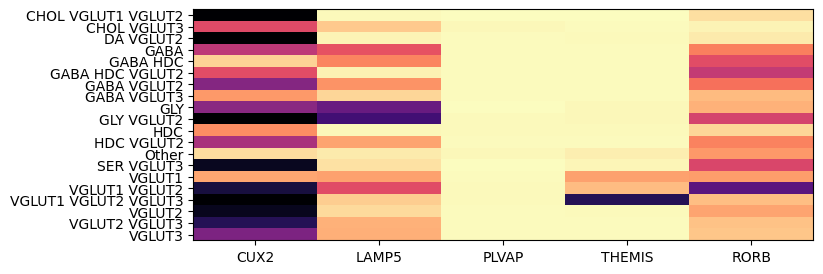

In [9]:
agg = aggregate_by_metadata(joined, gene_list, 'neurotransmitter')
agg = agg[gene_list]
res = plot_heatmap(agg, 8, 3)

We can also visualize the relationship between transport genes and neurotransmitter identities on the UMAP.

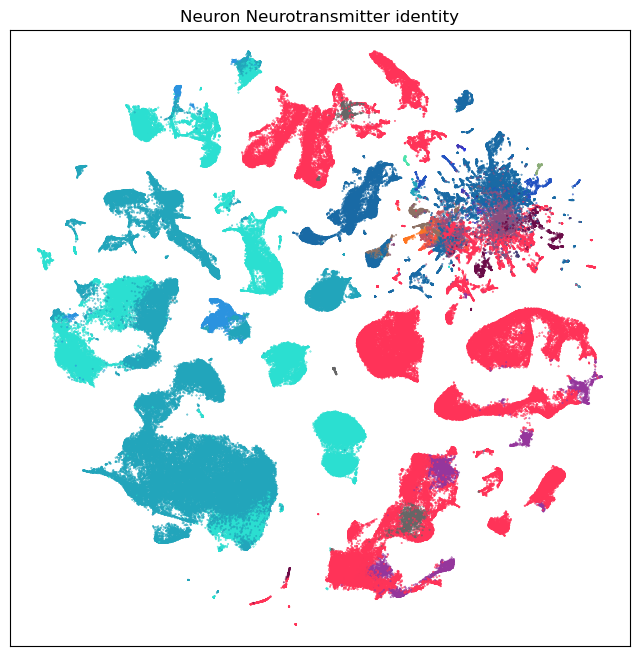

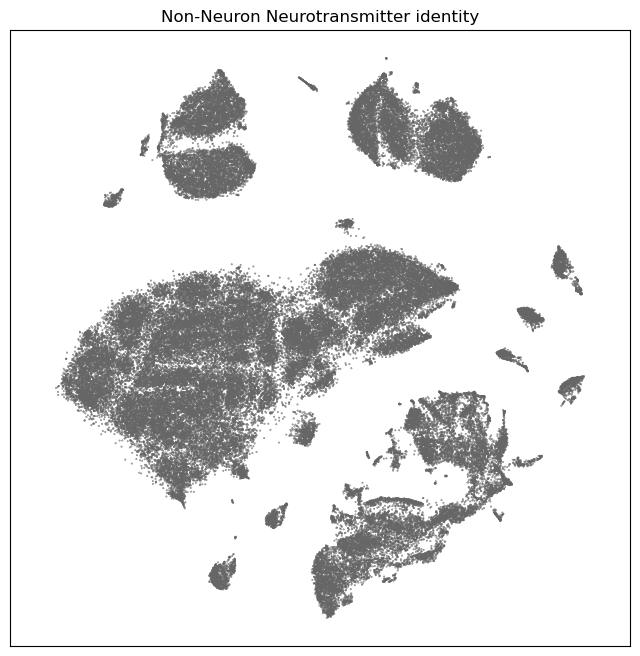

In [10]:
neurons_subsampled = joined[cell_extended['feature_matrix_label'] == 'WHB-10Xv3-Neurons'][::10]
non_neurons_subsampled = joined[cell_extended['feature_matrix_label'] == 'WHB-10Xv3-Nonneurons'][::10]
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], cc=neurons_subsampled['neurotransmitter_color'])
res = ax.set_title("Neuron Neurotransmitter identity")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], cc=non_neurons_subsampled['neurotransmitter_color'])
res = ax.set_title("Non-Neuron Neurotransmitter identity")

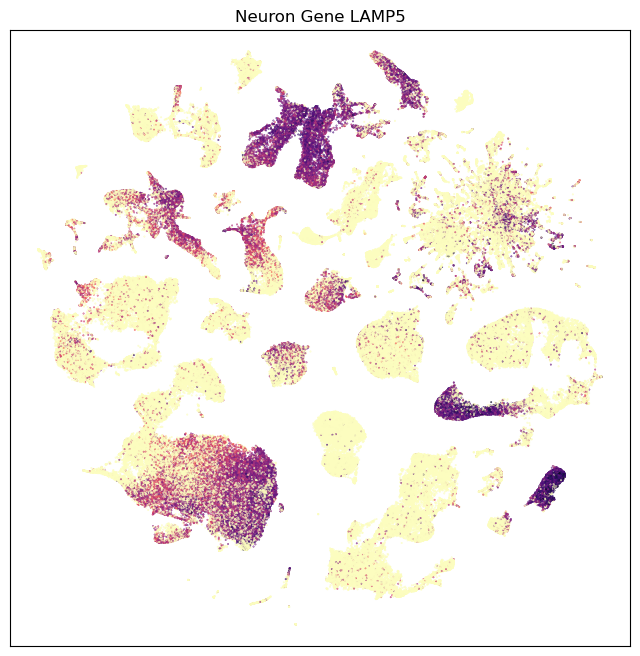

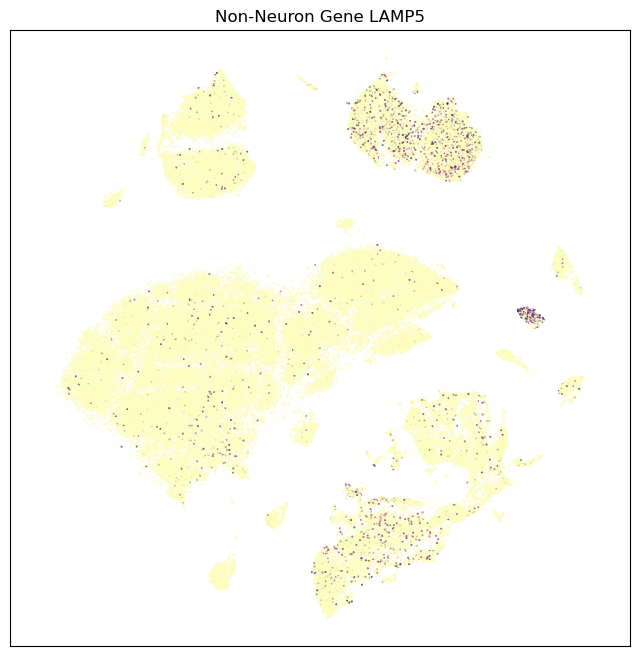

In [11]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['LAMP5'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron Gene LAMP5")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['LAMP5'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron Gene LAMP5")

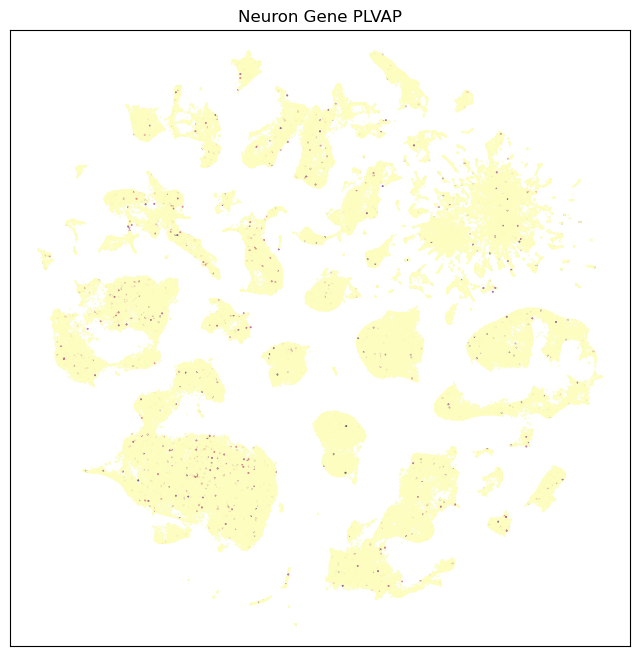

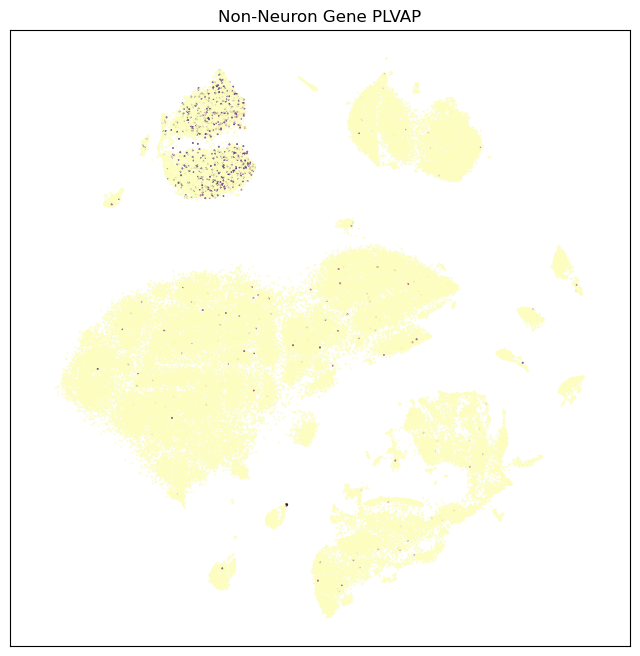

In [12]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['PLVAP'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron Gene PLVAP")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['PLVAP'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron Gene PLVAP")

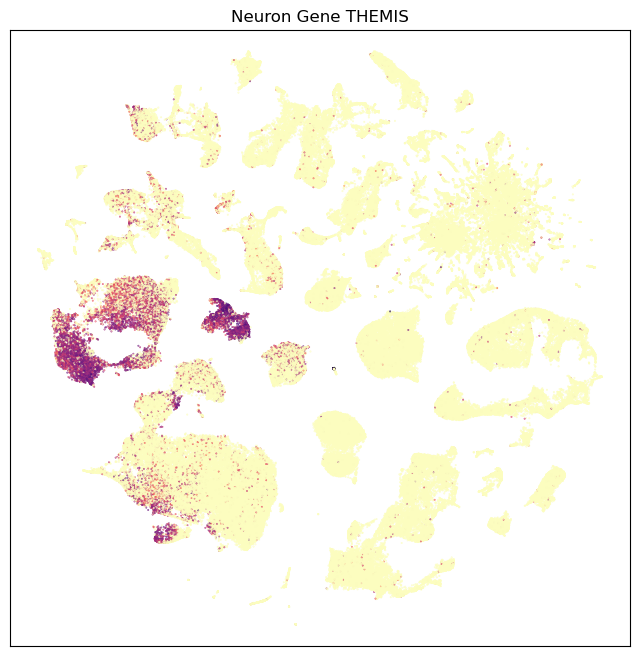

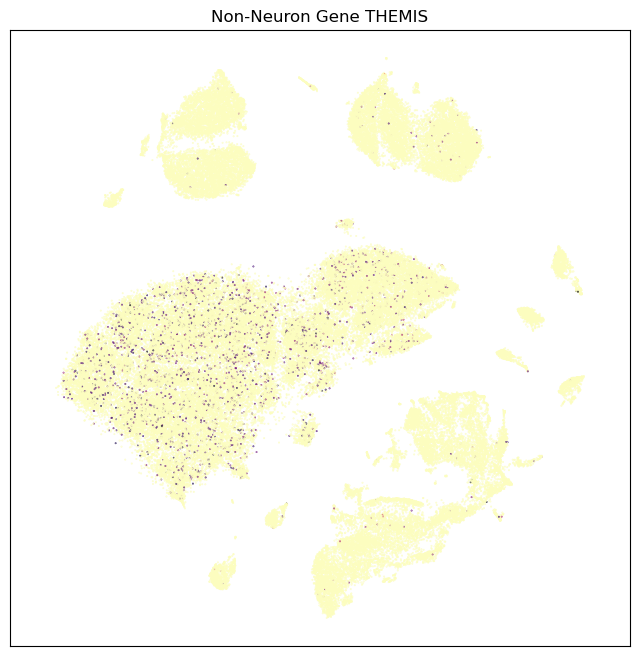

In [13]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['THEMIS'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron Gene THEMIS")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['THEMIS'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron Gene THEMIS")

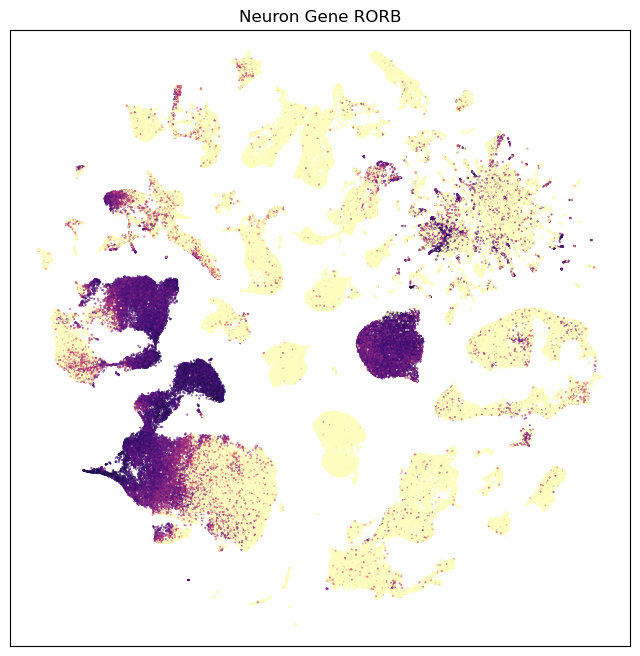

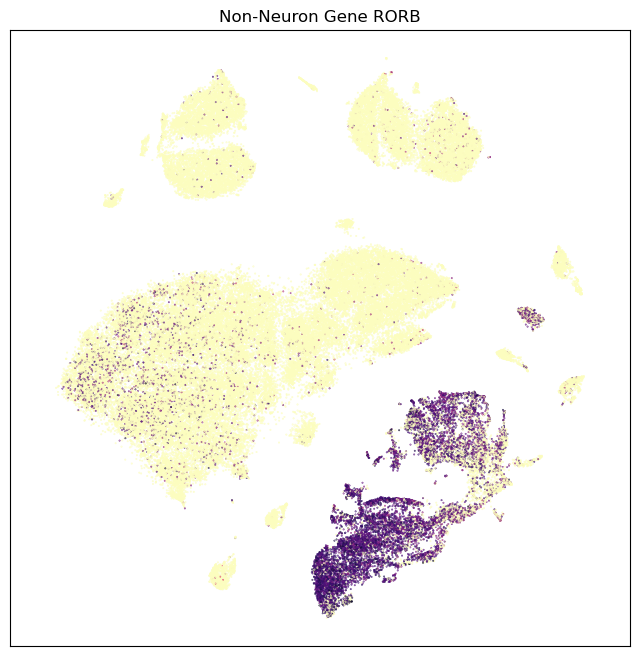

In [14]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], val=neurons_subsampled['RORB'], cmap=plt.cm.magma_r)
res = ax.set_title("Neuron Gene RORB")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], val=non_neurons_subsampled['RORB'], cmap=plt.cm.magma_r)
res = ax.set_title("Non-Neuron Gene RORB")

Grouping expression by dissection region of interest shows that each of these genes have distinct spatial patterns.

In [15]:
roi = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='region_of_interest_metadata')
roi.set_index('acronym', inplace=True)

In [16]:
joined.columns

Index(['cell_barcode', 'barcoded_cell_sample_label', 'library_label',
       'feature_matrix_label', 'entity', 'brain_section_label',
       'library_method', 'donor_label', 'donor_sex', 'dataset_label', 'x', 'y',
       'cluster_alias', 'region_of_interest_label',
       'anatomical_division_label', 'subcluster', 'cluster', 'supercluster',
       'neurotransmitter', 'subcluster_color', 'cluster_color',
       'supercluster_color', 'neurotransmitter_color', 'CUX2', 'LAMP5',
       'PLVAP', 'THEMIS', 'RORB'],
      dtype='object')

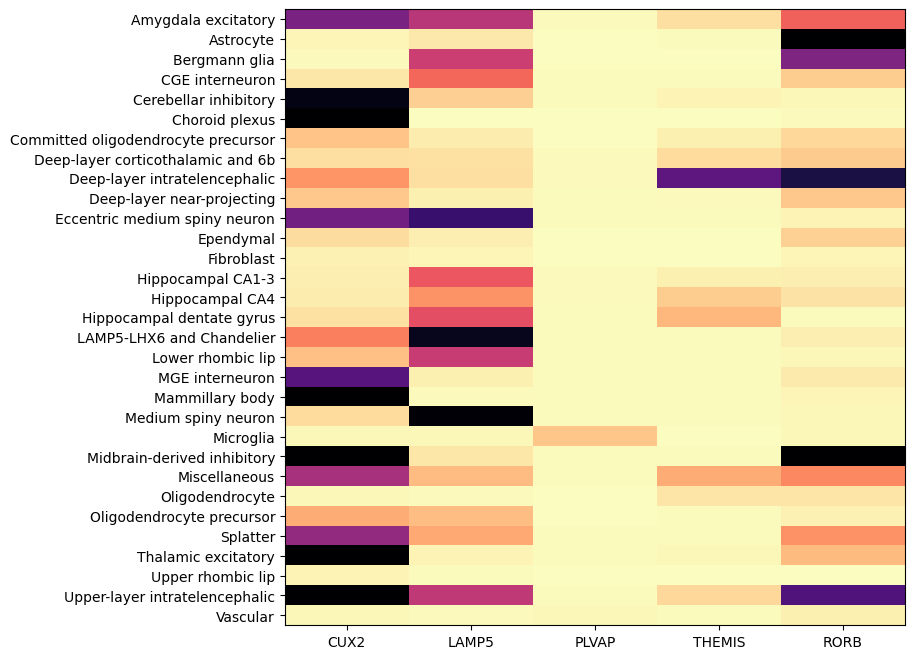

In [17]:
agg = aggregate_by_metadata(joined, gene_list, 'supercluster')
res = plot_heatmap(agg, 8, 8)